# IMDB二元分類實作解析

## 實作步驟
* Step1.載入基本套件與資料
* Step2.觀察資料
* Step3.資料前處理
* Step4.建立模型
* Step5.模型訓練
* Step6.訓練成效檢視

### Step1.載入基本套件與資料

keras在使用GPU時，默認會使用全部的記憶體，因此 keras 或 tensorflow 調用GPU時，若出現以下錯誤碼： Blas GEMM launch failed

代表GPU被其他程式占用，輸入以下程式即可解決。

參考資料
* keras指定GPU與限制顯示記憶體用量 https://www.cnblogs.com/wj-1314/p/11846622.html
* keras調用GPU報錯的解決方法 https://blog.csdn.net/Leo_Xu06/article/details/82023330
* tensorflow中使用tf.ConfigProto()配置Session运行参数&&GPU设备指定 https://blog.csdn.net/dcrmg/article/details/79091941

In [1]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto() #TF創建session時，對session進行配置
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3 #占用0.3的顯卡記憶體
config.gpu_options.allow_growth = True #不佔用所有記憶體，按需要分配
set_session(tf.Session(config=config)) 

Using TensorFlow backend.


In [2]:
#載入基本套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#載入資料
from keras.datasets import imdb
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000) #載入資料集，且限定對應字典中編號 0~9999 的單字載入

關於 IMDB 的詳細參數說明 https://keras.io/zh/datasets/

### Step2.觀察資料

In [3]:
#檢查訓練資料中的字詞最大編號是否與設定相符，也就是9999
max_index = max([max(sequence) for sequence in x_train])
print("字詞最大編號 : ",max_index)
print("\n")

#查資料個數的指令 len()
print("x_train數量 : ", len(x_train))
print("y_train數量 : ", len(y_train))
print("x_test數量 : ", len(x_test))
print("y_test數量 : ", len(y_test))
print("\n")

#Tensor的3個重要屬性，以train_images為例
print("x_train的階數為 : ",  x_train.ndim)
print("x_train的形狀為 : ", x_train.shape)
print("x_train的資料型態為 : ", x_train.dtype)
print("\n")

#檢視第一筆訓練資料
print("第一筆訓練資料", x_train[0])
#檢視第一筆分類標籤
print("第一筆對應標籤", y_train[0])

字詞最大編號 :  9999


x_train數量 :  25000
y_train數量 :  25000
x_test數量 :  25000
y_test數量 :  25000


x_train的階數為 :  1
x_train的形狀為 :  (25000,)
x_train的資料型態為 :  object


第一筆訓練資料 [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92

In [4]:
#檢視第一筆訓練資料對應的中文

#取得索引字典，會以{"字":對應編號}呈現
word_index = imdb.get_word_index()

#將{"字":對應編號}的順序交換，呈現{對應編號:"字"}
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

#將第一筆訓練資料解碼。
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in x_train[0]]) #見下方備註
print(decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

備註：

因為imdb保留0~2數字作為特殊用途，因此索引要調整成 i-3。
' '.join 語法的使用說明：https://www.runoob.com/python/att-string-join.html

### Step3.資料前處理

神經網路能接受輸入資料的類型為張量。將資料轉換成張量的過程，稱"資料向量化"。

In [5]:
#定義one hot encoder的函式
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #宣告大小為 len(sequences)*dimension 的零矩陣
    for i, sequence in enumerate(sequences): #為每個子串列編號
        results[i, sequence] = 1.  #將串列中有值的索引設為1
    return results

x_train_one_hot = vectorize_sequences(x_train)
x_test_one_hot = vectorize_sequences(x_test)

In [6]:
x_train_one_hot[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [7]:
#將訓練標籤與測試標籤向量化
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [8]:
#將訓練資料再拆分成訓練與驗證
x_validation = x_train_one_hot[:5000]
x_train_part = x_train_one_hot[5000:]
y_validation = y_train[:5000]
y_train_part = y_train[5000:]

### Step4.建立模型

In [9]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from keras.utils import np_utils

#建立模型
model = Sequential()
model.add(Dense(8, activation='relu', input_shape = (10000,)))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

#編譯模型
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Step5.模型訓練

In [10]:
#訓練模型
history = model.fit(x_train_part, y_train_part, batch_size = 512, epochs = 15, validation_data = (x_validation, y_validation))



Train on 20000 samples, validate on 5000 samples
Epoch 1/15




20000/20000 [==============================] - 3s 138us/step - loss: 0.6912 - acc: 0.5153 - val_loss: 0.6822 - val_acc: 0.6206
Epoch 2/15
20000/20000 [==============================] - 2s 100us/step - loss: 0.6746 - acc: 0.5656 - val_loss: 0.6504 - val_acc: 0.7830
Epoch 3/15
20000/20000 [==============================] - 2s 99us/step - loss: 0.6497 - acc: 0.6248 - val_loss: 0.5997 - val_acc: 0.8476
Epoch 4/15
20000/20000 [==============================] - 2s 99us/step - loss: 0.6210 - acc: 0.6708 - val_loss: 0.5461 - val_acc: 0.8698
Epoch 5/15
20000/20000 [==============================] - 2s 100us/step - loss: 0.5822 - acc: 0.7360 - val_loss: 0.4829 - val_acc: 0.8744
Epoch 6/15
20000/20000 [==============================] - 2s 101us/step - loss: 0.5453 - acc: 0.7654 - val_loss: 0.4359 - val_acc: 0.8824
Epoch 7/15
20000/20000 [==============================] - 2s 99us/step - loss: 0.5045 - acc: 0.7881 - val_loss: 0.4033 

### Step6.訓練成效檢視

In [11]:
history_dict = history.history #取得history中的所有物件
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

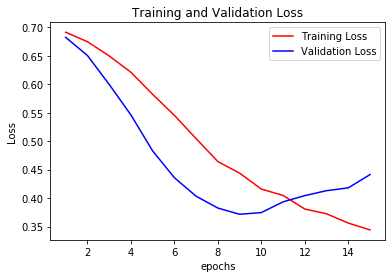

In [12]:
# 訓練與驗證分數的可視化
loss_values = history_dict['loss'] #取得每輪訓練所得的loss值
val_loss_values = history_dict['val_loss'] #取得每輪訓練所得的val_loss值

epochs = range(1, len(loss_values)+1) #訓練次數1~20

plt.plot(epochs, loss_values, 'r', label='Training Loss') #繪製 training loss 的圖形
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') #繪製 validation loss的圖形
plt.title('Training and Validation Loss') #設定圖表名稱
plt.xlabel('epochs') #設定x軸名稱為 epochs
plt.ylabel('Loss') #設定y軸名稱為 loss
plt.legend() #設定圖例
plt.show() #顯示圖形

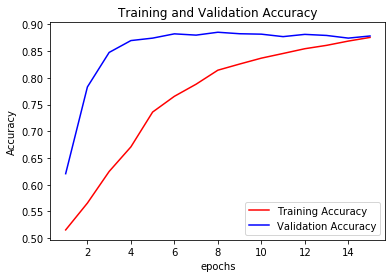

In [13]:
# plt.clf()  #清除圖表
acc_values = history_dict['acc'] #取得每輪訓練所得的loss值
val_acc_values = history_dict['val_acc'] #取得每輪訓練所得的val_loss值

epochs = range(1, len(loss_values)+1) #訓練次數1~20

plt.plot(epochs, acc_values, 'r', label='Training Accuracy') #繪製 training Accuracy 的圖形
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy') #繪製 validation Accuracy的圖形
plt.title('Training and Validation Accuracy') #設定圖表名稱
plt.xlabel('epochs') #設定x軸名稱為 epochs
plt.ylabel('Accuracy') #設定y軸名稱為 Accuracy
plt.legend() #設定圖例
plt.show() #顯示圖形

In [14]:
#預測
model.predict(x_test_one_hot)

array([[0.0341469 ],
       [0.7538386 ],
       [0.00476679],
       ...,
       [0.00383562],
       [0.01013255],
       [0.7538386 ]], dtype=float32)

In [15]:
validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation)
print("validation_loss:",validation_loss)
print("validation_accuracy:",validation_accuracy)

5000/5000 [==============================] - 1s 103us/step
validation_loss: 0.44133589544296264
validation_accuracy: 0.8784


In [16]:
Test_loss, Test_accuracy = model.evaluate(x_test_one_hot, y_test)
print("Test_loss:",Test_loss)
print("Test_accuracy:",Test_accuracy)

25000/25000 [==============================] - 3s 101us/step
Test_loss: 0.4791428091430664
Test_accuracy: 0.86496


備註：
model.evaluate()會回傳loss value & metrics values。此處的metrics values為accuracy。